<a href="https://colab.research.google.com/github/oroverdino/EdDM/blob/main/examenFinal_EdDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Final EdDM

## Objetivo

_El conjunto de datos asignado corresponde a salarios de trabajadores de análisis de datos, usted deberá tratar de obtener información descriptiva sobre los salarios y encontrar características de los salarios mejores pagos._

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%load_ext rpy2.ipython

En principio voy a cargar los paquetes necesarios para el primer analisis de la database cruda.

In [4]:
%%R
library(data.table)

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com



In [31]:
%%R

setwd('/content/drive/MyDrive/EdDM/examenFinal/Datasets')
#saveRDS(DT, 'DT_rev01.rds')
saveRDS(DT, 'DT_rev02.rds')

Desde ahora solo tengo que cargar el archivo rds para retomar el trabajo.

In [5]:
%%R

setwd('/content/drive/MyDrive/EdDM/examenFinal/Datasets')
#DT <- readRDS('DT_rev01.rds')
DT <- readRDS('DT_rev02.rds') # fin analisis univariado

In [ ]:
%%R
DT_raw <- fread('/content/drive/MyDrive/EdDM/examenFinal/Datasets/Salarios.csv')

In [ ]:
%%R
print(str(DT_raw))
print(dim(DT_raw))

Classes ‘data.table’ and 'data.frame':	607 obs. of  12 variables:
 $ V1                : int  0 1 2 3 4 5 6 7 8 9 ...
 $ work_year         : int  2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 ...
 $ experience_level  : chr  "MI" "SE" "SE" "MI" ...
 $ employment_type   : chr  "FT" "FT" "FT" "FT" ...
 $ job_title         : chr  "Data Scientist" "Machine Learning Scientist" "Big Data Engineer" "Product Data Analyst" ...
 $ salary            : int  70000 260000 85000 20000 150000 72000 190000 11000000 135000 125000 ...
 $ salary_currency   : chr  "EUR" "USD" "GBP" "USD" ...
 $ salary_in_usd     : int  79833 260000 109024 20000 150000 72000 190000 35735 135000 125000 ...
 $ employee_residence: chr  "DE" "JP" "GB" "HN" ...
 $ remote_ratio      : int  0 0 50 0 50 100 100 50 100 50 ...
 $ company_location  : chr  "DE" "JP" "GB" "HN" ...
 $ company_size      : chr  "L" "S" "M" "S" ...
 - attr(*, ".internal.selfref")=<externalptr> 
NULL
[1] 607  12


Veo que la base de datos cuenta con 12 variables y 607 registros. Me fijo si tiene registros duplicados.

In [ ]:
%%R

sum(duplicated(DT_raw))

[1] 0


No tiene registros duplicados. Me fijo si tiene registros con datos nulos.

In [ ]:
%%R

DT_raw[, lapply(.SD, function(x) sum(is.na(x)))]

   V1 work_year experience_level employment_type job_title salary
1:  0         0                0               0         0      0
   salary_currency salary_in_usd employee_residence remote_ratio
1:               0             0                  0            0
   company_location company_size
1:                0            0


No tiene datos nulos. A esta altura me estoy inclinando a pensar que la database esta limpia de artefactos.

Voy a corregir los tipos de variables y guardar el resultado en una nueva dataframe en un archivo RDS para empezar desde ahi.

In [ ]:
%%R

DT <- DT_raw
DT$work_year <- as.factor(DT$work_year)
DT$experience_level <- as.factor(DT$experience_level)
DT$employment_type <- as.factor(DT$employment_type)
DT$job_title <- as.factor(DT$job_title)
DT$salary_currency <- as.factor(DT$salary_currency)
DT$employee_residence <- as.factor(DT$employee_residence)
DT$remote_ratio <- as.factor(DT$remote_ratio)
DT$company_location <- as.factor(DT$company_location)
DT$company_size <- as.factor(DT$company_size)

In [ ]:
%%R

print(str(DT))
print(dim(DT))

Classes ‘data.table’ and 'data.frame':	607 obs. of  12 variables:
 $ V1                : int  0 1 2 3 4 5 6 7 8 9 ...
 $ work_year         : Factor w/ 3 levels "2020","2021",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ experience_level  : Factor w/ 4 levels "EN","EX","MI",..: 3 4 4 3 4 1 4 3 3 4 ...
 $ employment_type   : Factor w/ 4 levels "CT","FL","FT",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ job_title         : Factor w/ 50 levels "3D Computer Vision Researcher",..: 23 41 8 48 38 13 35 23 9 34 ...
 $ salary            : int  70000 260000 85000 20000 150000 72000 190000 11000000 135000 125000 ...
 $ salary_currency   : Factor w/ 17 levels "AUD","BRL","CAD",..: 8 17 9 17 17 17 17 10 17 17 ...
 $ salary_in_usd     : int  79833 260000 109024 20000 150000 72000 190000 35735 135000 125000 ...
 $ employee_residence: Factor w/ 57 levels "AE","AR","AT",..: 15 33 21 24 56 56 56 26 56 42 ...
 $ remote_ratio      : Factor w/ 3 levels "0","50","100": 1 1 2 1 2 3 3 2 3 2 ...
 $ company_location  : Factor w/ 50 levels "

En ppio descarto la primer variable _V1_ que es la ID de cada registro.

In [ ]:
%%R

DT[, c('V1') := NULL]

In [ ]:
%%R

str(DT)

Todavía no sé cuáles variables van a ser importantes para los objetivos. Por lo tanto analizo cada una.

In [6]:
%%R

ftable(DT$work_year)

 2020 2021 2022
               
   72  217  318


La variable _work_year_ tiene el año 2022 con más del 50% de todos los años recolectados. Los otros valores posibles son 2020 (con 12%) y 2021 (con 35%).

Debido a la cuarentena a nivel mundial durante 2020 y parte de 2021 considero razonable reclasificar los niveles de ésta variable. Quedando 2022ec y ad2022 (2022 en curso y antes de 2022 respectivamente).

In [ ]:
%%R

DT[, setattr(work_year, 'levels', c('ad2022','ad2022','2022ec'))]

In [ ]:
%%R

ftable(DT$experience_level)

  EN  EX  MI  SE
                
  88  26 213 280


La variable _experience_level_ tiene 4 niveles:

1.   EN: entry-level / junior
2.   MI: mid-level / intermediate
3.   SE: senior-level / expert
4.   EX: executive-level / director

Consulté varias fuentes sobre si era conveniente reclasificar los factores en sólo dos: EN y MI -> junior, SE y EX -> senior. Resulta que éstos cuatro 
niveles son los que la industria considera a la hora de decidir los sueldos. Por lo tanto no considero conveniente la reclasificación.


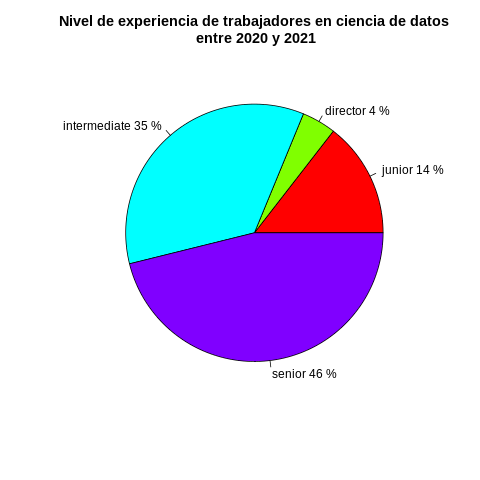

In [80]:
%%R

porcentaje <- round(table(DT$experience_level) / sum(table(DT$experience_level)) * 100)
etiqueta <- paste(c('junior', 'director', 'intermediate', 'senior'), porcentaje, '%')
pie(ftable(DT$experience_level),
    labels = etiqueta,
    col = rainbow(length(etiqueta)),
    main = "Nivel de experiencia de trabajadores en ciencia de datos\n entre 2020 y 2021"
)

In [ ]:
%%R

ftable(DT$employment_type)

  CT  FL  FT  PT
                
   5   4 588  10


La variable _employment_type_ tiene 4 niveles:

1. CT: contract
2. FL: freelance
3. FT: full-time
4. PT: part-time

Casi el 97% de los tipos de empleo son de tiempo completo.

In [ ]:
%%R

etiqueta <- levels(DT$employment_type)
barplot(table(DT$employment_type),
        #labels = etiqueta,
        horiz = TRUE,
)

In [110]:
%%R

top10 <- as.data.table(ftable(DT$job_title))
JT <- top10[rev(order(top10$Freq))] 

In [113]:
%%R

head(JT, 25)

                                  Var1 Freq
 1:                     Data Scientist  143
 2:                      Data Engineer  132
 3:                       Data Analyst   97
 4:          Machine Learning Engineer   41
 5:                 Research Scientist   16
 6:               Data Science Manager   12
 7:                     Data Architect   11
 8:         Machine Learning Scientist    8
 9:                  Big Data Engineer    8
10:           Principal Data Scientist    7
11:           Director of Data Science    7
12:            Data Science Consultant    7
13:             Data Analytics Manager    7
14:                       AI Scientist    7
15:                        ML Engineer    6
16:                 Lead Data Engineer    6
17:           Computer Vision Engineer    6
18:                    BI Data Analyst    6
19:                       Head of Data    5
20:           Data Engineering Manager    5
21:              Business Data Analyst    5
22:             Applied Data Sci

La variable _job_title_ tiene 50 niveles. El valor más frecuente aparece en menos del 25% de los registros.

Pensé que una _nube de palabras_ podría echar claridad sobre el análisis. Sólo incluí las palabras que se repetían al menos el 10% del total.

In [64]:
%%R

# para separar las palabras el tipo debe ser character
DT$job_title <- as.character(DT$job_title)

DT_titulos <- DT[, .(palabra = unlist(strsplit(job_title, ' '), use.names = FALSE))][, .N, by = palabra]

In [ ]:
%%R

#install.packages('wordcloud')
library(wordcloud)

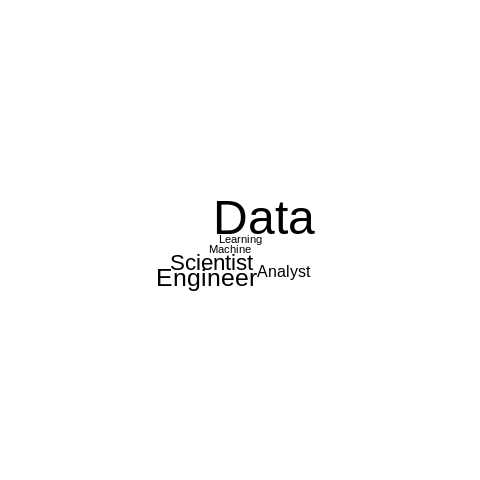

In [65]:
%%R

wordcloud(DT_titulos$palabra, freq = DT_titulos$N, min.freq = 60)

In [88]:
%%R

DT$job_title <- as.factor(DT$job_title)
titulos <- levels(DT$job_title)
cantidad <- ftable(DT$job_title)[1,]

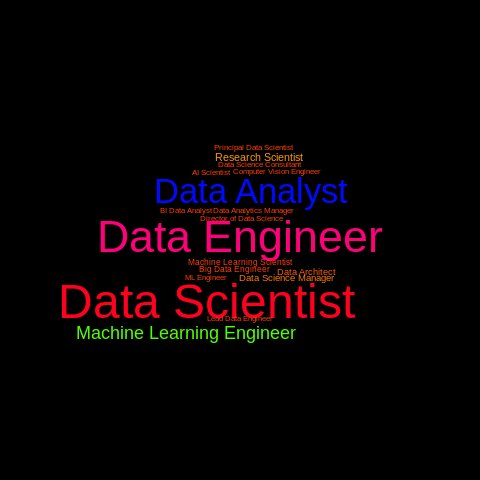

In [103]:
%%R

par(bg = 'black')
wordcloud(titulos, cantidad, min.freq = 6,
          col = rainbow(length(titulos)),
          #scale = c(21,1)
)

In [ ]:
%%R

summary(DT$salary)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    4000    70000   115000   324000   165000 30400000 


La variable _salary_ en principio parece la de mayor interés para los objetivos. Es una variable numérica que sólo tiene sentido si va acompañada de la variable _salary_currency_.

Dado que los objetivos del presente trabajo son:

*   información descriptiva de los salarios
*   características de los mejores pagos

Necesito convertir la moneda de cada país con una moneda de referencia. Para mi conveniencia la variable _salary_in_usd_ tiene esa información.

Por lo tanto las variables _salary_ y _salary_currency_ no van a ser partes de mi análisis. La variable _employee_residence_ hace innecesaria la variable _salary_currency_.

Al menos en ésta primera inspección.



In [115]:
%%R

IQR(DT$salary_in_usd)

[1] 87274


El rango intercuartil me indica cuál es la diferencia entre el que más gana y el que menos ganas dentro del 50% de los trabajadores.

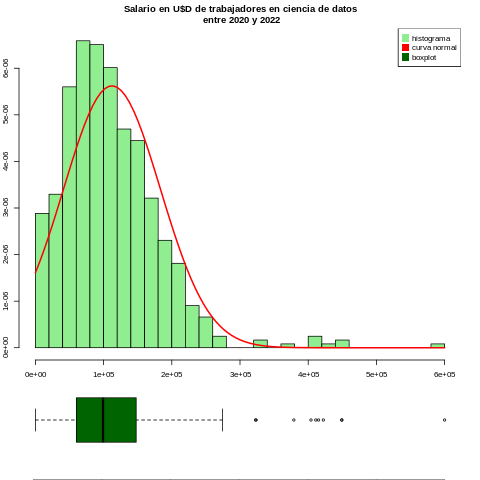

In [148]:
%%R

#setwd('/content/drive/MyDrive/EdDM/examenFinal/Datasets') 
#png(file='hist.png', width = 600, height = 350)

layout(matrix(c(1, 1, 1, 2), nrow = 4, ncol = 1, byrow = TRUE))
 
par(mar = c(0,2,3,2))
hist(DT$salary_in_usd,
     breaks = 'FD',
     main = 'Salario en U$D de trabajadores en ciencia de datos\n entre 2020 y 2022',
     freq = FALSE,
     col = 'lightgreen',
     xlab = '',
     ylab = ''
)

curve(dnorm(x, mean = mean(DT$salary_in_usd), sd = sd(DT$salary_in_usd)),
      add = TRUE,
      col = 'red',
      lwd = 2
)

legend('topright',
       legend = c('histograma','curva normal', 'boxplot'),
       col = c('lightgreen','red', 'darkgreen'),
       pt.cex = 2,
       pch = 15
)

par(mar = c(0,2,0,2))
boxplot(DT$salary_in_usd,
        horizontal = TRUE,
        col = 'darkgreen',
        frame = F
)

#dev.off()

Los outliers deberán analizarse en función de otras variables, por ejemplo _experience_level_. Es por eso que no los elimino directamente del dataset. Con sólo 10 outliers son menos del 10% del total de registros.

Otra razón para no eliminarlos es que son outliers de máximos valores. Son parte de los objetivos.

In [12]:
%%R

print(ftable(boxplot.stats(DT$salary_in_usd)$out))
print(sum(table(boxplot.stats(DT$salary_in_usd)$out)))

 324000 325000 380000 405000 412000 416000 423000 450000 600000
                                                               
      1      1      1      1      1      1      1      2      1
[1] 10


Me fijé en los registros donde se dan los outliers. Todos viven en US, no hay un título que se repita, el 90% trabajó full-time (probablemente el único contratado también), no hay ningún junior y la mayoría trabajó casi en su totalidad de manera remota.

In [49]:
%%R

DT[DT$salary_in_usd >= 324e+03, ]

    work_year experience_level employment_type
 1:    ad2022               EX              FT
 2:    ad2022               MI              FT
 3:    ad2022               SE              FT
 4:    ad2022               MI              FT
 5:    ad2022               MI              FT
 6:    ad2022               EX              CT
 7:    ad2022               EX              FT
 8:    2022ec               EX              FT
 9:    2022ec               SE              FT
10:    2022ec               SE              FT
                             job_title salary salary_currency salary_in_usd
 1:           Director of Data Science 325000             USD        325000
 2:                 Research Scientist 450000             USD        450000
 3:                     Data Scientist 412000             USD        412000
 4:             Financial Data Analyst 450000             USD        450000
 5: Applied Machine Learning Scientist 423000             USD        423000
 6:           Principal Dat

In [5]:
%%R

install.packages('moments', quiet = TRUE)
library(moments)

In [23]:
%%R

moda <- function(x) unique(x)[which.max(table(x))]

In [8]:
%%R

print(skewness(DT$salary_in_usd))
print(kurtosis(DT$salary_in_usd)) 

[1] 1.663421
[1] 9.291709


In [27]:
%%R

print(mean(DT$salary_in_usd))
print(median(DT$salary_in_usd))
print(moda(DT$salary_in_usd))

[1] 112297.9
[1] 101570
[1] 18907


La curtosis de la distribución de la variable _salary_in_usd_ es mayor a 3, por lo que se trata de una curva leptocúrtica. Esto me indica que la población es homogenea a pesar de los outliers.

La variable _salary_in_usd_ tiene el promedio ligeramente mayor que la media, y la media es a su vez mayor que la moda. La distribución es asimétrica a la derecha, o positiva.

In [22]:
%%R

length(ftable(DT$employee_residence))

[1] 57


La variable categórica _employee_residence_ tiene 57 niveles. Utilicé el mismo criterio usado con la variable _job_title_: sólo listar los valores con más de 6 ocurrencias. Resultó que más del 50% de los empleados vive es US.

In [107]:
%%R

palabras <- levels(DT$employee_residence)
cantidad <- ftable(DT$employee_residence)[1,]

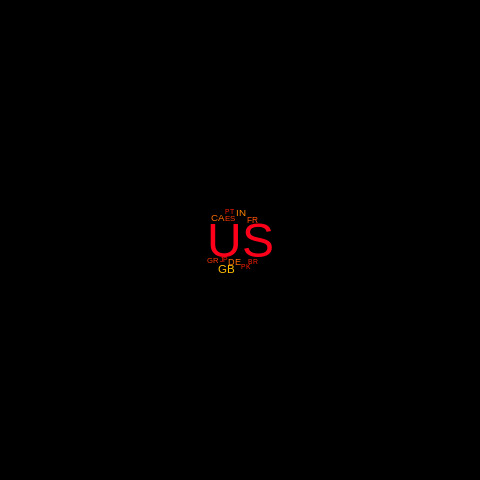

In [109]:
%%R

par(bg='black')
wordcloud(palabras, freq = cantidad, min.freq = 6,
          col = rainbow(length(palabras))
)

In [23]:
%%R

ftable(DT$remote_ratio)

   0  50 100
            
 127  99 381


La variable _remote_ratio_ indica la proporción del trabajo que fue realizado en remoto. Donde los niveles indican:

* 0 : sin trabajo remoto o menos del 20%
* 50 : parcialmente remoto
* 100 : completamente remoto o más del 80%

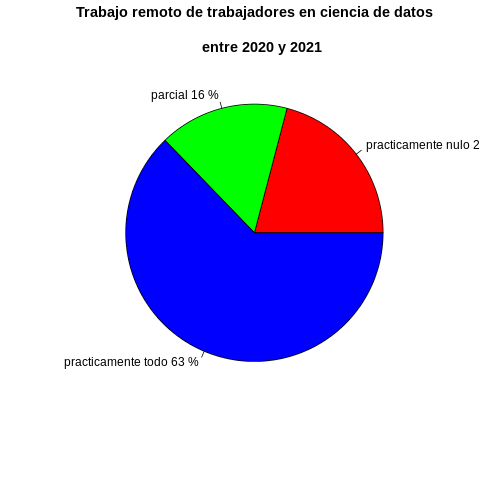

In [17]:
%%R

porcentaje <- round(table(DT$remote_ratio) / sum(table(DT$remote_ratio)) * 100)
etiqueta <- paste(c('practicamente nulo', 'parcial', 'practicamente todo'), porcentaje, '%')
pie(ftable(DT$remote_ratio),
    labels = etiqueta,
    col = rainbow(length(etiqueta)),
    main = 'Trabajo remoto de trabajadores en ciencia de datos\n
    entre 2020 y 2021'
)

In [110]:
%%R

palabras <- levels(DT$company_location)
cantidad <- ftable(DT$company_location)[1,]

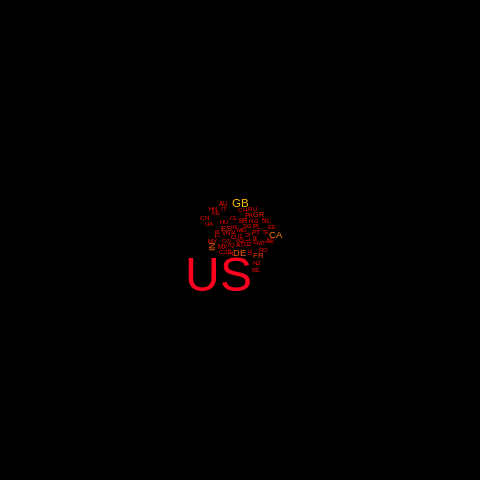

In [113]:
%%R

par(bg = 'black')
wordcloud(palabras, freq = cantidad, min.freq = 1,
          col = rainbow(length(palabras))
)

In [33]:
%%R

ftable(DT$company_size)

   L   M   S
            
 198 326  83


La variable _company_size_ indica el tamaño de la empresa donde el trabajador recibe el sueldo. Los niveles son de acuerdo a la cantidad de gente de la empresa:

* S: menos de 50 empleados
* M: entre 50 y 250 empleados
* L: más de 250 empleados

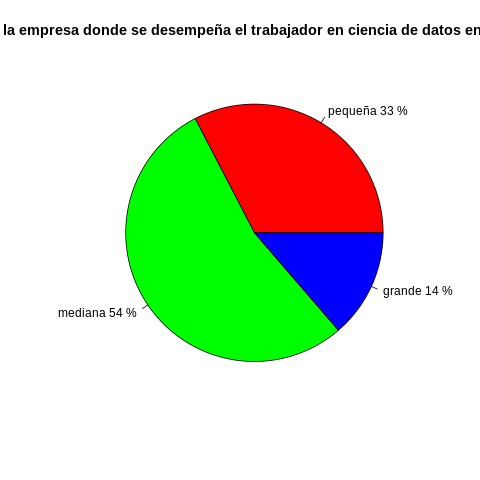

In [35]:
%%R

porcentaje <- round(table(DT$company_size) / sum(table(DT$company_size)) * 100)
etiqueta <- paste(c('pequeña', 'mediana', 'grande'), porcentaje, '%')
pie(ftable(DT$company_size),
    labels = etiqueta,
    col = rainbow(length(etiqueta)),
    main = 'Tamaño de la empresa donde se desempeña\ el trabajador en ciencia de datos entre 2020 y 2021'
)



---



In [ ]:
%%R



In [128]:
%%R

DT[, .(promedio = mean(salary_in_usd)), by = experience_level]

   experience_level  promedio
1:               MI  64000.00
2:               SE  70000.00
3:               EN  57920.75
4:               EX 103743.50


In [ ]:
%%R

DT[, .('moda' = moda(salary_in_usd)), by = experience_level]

   experience_level   moda
1:               MI  66022
2:               SE  99000
3:               EN  31875
4:               EX 325000


In [133]:
%%R

DT[, .(media = median(salary_in_usd)), by = work_year]

   work_year  media
1:    ad2022  81000
2:    2022ec 120000


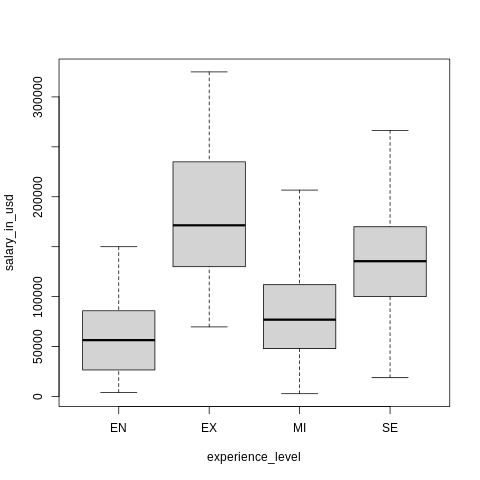

In [ ]:
%%R

plot(DT[, salary_in_usd, by = experience_level], outline = F)

In [ ]:
%%R

DT_raw[, lapply(.SD, table), .SDcols = 9:10])

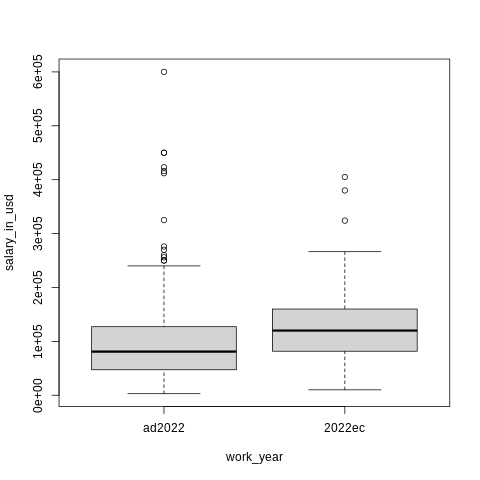

In [50]:
%%R

plot(DT[, salary_in_usd, by = work_year])

In [13]:
%%R

levels(DT$experience_level)

[1] "EN" "EX" "MI" "SE"


In [ ]:
%%R

colors <- numeric(4)
colors[experience_level == 'EN'] <- 'green'
colors[experience_level == 'MI'] <- 'orange'
colors[experience_level == 'SE'] <- 'blue'
colors[experience_level == 'EX'] <- 'red'

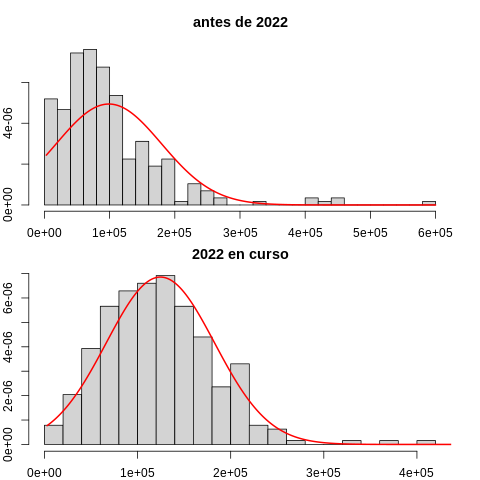

In [80]:
%%R

layout(matrix(c(1,2), byrow = TRUE))

Xad <- DT[ work_year == 'ad2022', salary_in_usd]
Xec <- DT[ work_year == '2022ec', salary_in_usd]
x <- seq(min(DT$salary_in_usd), max(DT$salary_in_usd))

par(mar = c(2,2,3,2))
hist(Xad,
     prob = TRUE,
     breaks = round(sqrt(nrow(DT))),
     main = 'antes de 2022'
)
fad <- dnorm(x, mean = mean(Xad), sd = sd(Xad))
lines(x, fad, col = 'red', lwd = 2)

par(mar = c(2,2,2,2))
hist(Xec,
     prob = TRUE,
     breaks = round(sqrt(nrow(DT))),
     main = '2022 en curso'
)
fec <- dnorm(x, mean = mean(Xec), sd = sd(Xec))
lines(x, fec, col = 'red', lwd = 2)


 ---  
 Calculo de outliers multivariados (clase12, 40min)
 ---

In [ ]:
%%R

install.packages('MASS', quiet = TRUE)
install.packages('lattice', quiet = TRUE)
install.packages('grid', quiet = TRUE)
install.packages('DMwR2', quiet = TRUE)
library('MASS', quiet = TRUE)
library('lattice', quiet = TRUE)
library('grid', quiet = TRUE)
library('DMwR2', quiet = TRUE)

In [152]:
%%R

salarioWY <- DT[, .(salary, salary_in_usd)]

In [ ]:
%%R

cov1 <- cov.rob(salarioWY, method = 'mcd', nsamp = 'exact')

From cffi callback <function _processevents at 0x7fc55fc96170>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7fc55fc96170>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


In [151]:
%%R

center1 <- apply(salarioWY, 2, mean)
center2 <- apply(salarioWY, 2, median)

  dim(X) must have a positive length




Error in apply(salarioWY[, salary_in_usd], 2, mean) : 
  dim(X) must have a positive length


RInterpreterError: ignored